In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.io as isoio
import isolearn.keras as isol

from genesis.visualization import *
from genesis.generator import *
from genesis.predictor import *
from genesis.optimizer import *
import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.stats import pearsonr

import seaborn as sns

from matplotlib import colors

import editdistance

def subselect_list(li, ixs) :
    return [
        li[ixs[k]] for k in range(len(ixs))
    ]

class IdentityEncoder(iso.SequenceEncoder) :
    
    def __init__(self, seq_len, channel_map) :
        super(IdentityEncoder, self).__init__('identity', (seq_len, len(channel_map)))
        
        self.seq_len = seq_len
        self.n_channels = len(channel_map)
        self.encode_map = channel_map
        self.decode_map = {
            nt: ix for ix, nt in self.encode_map.items()
        }
    
    def encode(self, seq) :
        encoding = np.zeros((self.seq_len, self.n_channels))
        
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.

        return encoding
    
    def encode_inplace(self, seq, encoding) :
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementError()
    
    def decode(self, encoding) :
        seq = ''
    
        for pos in range(0, encoding.shape[0]) :
            argmax_nt = np.argmax(encoding[pos, :])
            max_nt = np.max(encoding[pos, :])
            seq += self.decode_map[argmax_nt]

        return seq
    
    def decode_sparse(self, encoding_mat, row_index) :
        raise NotImplementError()

#Plot joint histograms
def plot_joint_histo(measurements, labels, x_label, y_label, colors=None, n_bins=50, figsize=(6, 4), legend_outside=False, save_fig=False, fig_name="default_1", fig_dpi=150, min_val=None, max_val=None, max_y_val=None) :
    
    min_hist_val = np.min(measurements[0])
    max_hist_val = np.max(measurements[0])
    for i in range(1, len(measurements)) :
        min_hist_val = min(min_hist_val, np.min(measurements[i]))
        max_hist_val = max(max_hist_val, np.max(measurements[i]))
    
    if min_val is not None :
        min_hist_val = min_val
    if max_val is not None :
        max_hist_val = max_val

    hists = []
    bin_edges = []
    means = []
    for i in range(len(measurements)) :
        hist, b_edges = np.histogram(measurements[i], range=(min_hist_val, max_hist_val), bins=n_bins, density=True)
        
        hists.append(hist)
        bin_edges.append(b_edges)
        means.append(np.mean(measurements[i]))
    
    bin_width = bin_edges[0][1] - bin_edges[0][0]


    f = plt.figure(figsize=figsize)

    for i in range(len(measurements)) :
        if colors is not None :
            plt.bar(bin_edges[i][1:] - bin_width/2., hists[i], width=bin_width, linewidth=2, edgecolor='black', color=colors[i], label=labels[i])
        else :
            plt.bar(bin_edges[i][1:] - bin_width/2., hists[i], width=bin_width, linewidth=2, edgecolor='black', label=labels[i])
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.xlim(min_hist_val, max_hist_val)
    if max_y_val is not None :
        plt.ylim(0, max_y_val)

    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)

    if colors is not None :
        for i in range(len(measurements)) :
            plt.axvline(x=means[i], linewidth=2, color=colors[i], linestyle="--")

    if not legend_outside :
        plt.legend(fontsize=14, loc='upper left')
    else :
        plt.legend(fontsize=14, bbox_to_anchor=(1.04,1), loc="upper left")
    
    plt.tight_layout()
    
    if save_fig :
        plt.savefig(fig_name + ".eps")
        plt.savefig(fig_name + ".svg")
        plt.savefig(fig_name + ".png", dpi=fig_dpi, transparent=True)
    
    plt.show()

#Plot join histograms
def plot_joint_cmp(measurements, labels, y_label, plot_type='violin', colors=None, figsize=(6, 4), legend_outside=False, save_fig=False, fig_name="default_1", fig_dpi=150, min_y_val=None, max_y_val=None) :
    
    f = plt.figure(figsize=figsize)

    sns_g = None
    if colors is not None :
        if plot_type == 'violin' :
            sns_g = sns.violinplot(data=measurements, palette=colors, scale='width') #, x=labels
        elif plot_type == 'strip' :
            sns_g = sns.stripplot(data=measurements, palette=colors, alpha=0.1, jitter=0.3, linewidth=2, edgecolor='black') #, x=labels
            for i in range(len(measurements)) :
                plt.plot(x=[i, i+1], y=[np.median(measurements[i]), np.median(measurements[i])], linewidth=2, color=colors[i], linestyle="--")
        elif plot_type == 'bar' :
            for i in range(len(measurements)) :
                plt.bar([i], [np.percentile(measurements[i], 95)], width=0.4, color=colors[i], label=str(i) + ") " + labels[i], linewidth=2, edgecolor='black')
                plt.bar([i+0.2], [np.percentile(measurements[i], 80)], width=0.4, color=colors[i], linewidth=2, edgecolor='black')
                plt.bar([i+0.4], [np.percentile(measurements[i], 50)], width=0.4, color=colors[i], linewidth=2, edgecolor='black')
    else :
        if plot_type == 'violin' :
            sns_g = sns.violinplot(data=measurements, scale='width') #, x=labels
        elif plot_type == 'strip' :
            sns_g = sns.stripplot(data=measurements, alpha=0.1, jitter=0.3, linewidth=2, edgecolor='black') #, x=labels
        elif plot_type == 'bar' :
            for i in range(len(measurements)) :
                plt.bar([i], [np.percentile(measurements[i], 95)], width=0.25, label=str(i) + ") " + labels[i], linewidth=2, edgecolor='black')
                plt.bar([i+0.125], [np.percentile(measurements[i], 80)], width=0.25, linewidth=2, edgecolor='black')
                plt.bar([i+0.25], [np.percentile(measurements[i], 50)], width=0.25, linewidth=2, edgecolor='black')
    
    plt.xticks(np.arange(len(labels)), fontsize=14)
    plt.yticks(fontsize=14)
    
    #plt.xlim(min_hist_val, max_hist_val)
    if min_y_val is not None and max_y_val is not None :
        plt.ylim(min_y_val, max_y_val)

    plt.ylabel(y_label, fontsize=14)
    
    if plot_type not in ['violin', 'strip'] :
        if not legend_outside :
            plt.legend(fontsize=14, loc='upper left')
        else :
            plt.legend(fontsize=14, bbox_to_anchor=(1.04,1), loc="upper left")
    else :
        if not legend_outside :
            f.get_axes()[0].legend(fontsize=14, loc="upper left", labels=[str(label_i) + ") " + label for label_i, label in enumerate(labels)])
        else :
            f.get_axes()[0].legend(fontsize=14, bbox_to_anchor=(1.04,1), loc="upper left", labels=[str(label_i) + ") " + label for label_i, label in enumerate(labels)])
    
    plt.tight_layout()
    
    if save_fig :
        plt.savefig(fig_name + ".eps")
        plt.savefig(fig_name + ".svg")
        plt.savefig(fig_name + ".png", dpi=fig_dpi, transparent=True)
    
    plt.show()

#Load generated data from models to be evaluated

def load_sequences(file_path, split_on_tab=True, seq_template=None, max_n_sequences=1e6, select_best_fitness=False, predictor=None, batch_size=32) :
    seqs = []
    
    with open(file_path, "rt") as f :
        for l in f.readlines() :
            l_strip = l.strip()
            seq = l_strip
            if split_on_tab :
                seq = l_strip.split("\t")[0]
            
            if seq_template is not None :
                seq = ''.join([
                    seq_template[j] if seq_template[j] != 'N' else seq[j]
                    for j in range(len(seq))
                ])

            seqs.append(seq)
        
    if select_best_fitness and predictor is not None :
        onehots = np.expand_dims(np.concatenate([
            np.expand_dims(acgt_encoder.encode(seq), axis=0) for seq in seqs
        ], axis=0), axis=-1)

        #Predict fitness
        score_pred = predictor.predict(x=[onehots[..., 0]], batch_size=batch_size)
        score_pred = np.ravel(score_pred[:, 5])
        
        sort_index = np.argsort(score_pred)[::-1]
        seqs = [
            seqs[sort_index[i]] for i in range(len(seqs))
        ]
    
    return seqs[:max_n_sequences]

#Evaluate metrics for each model

def compute_metrics(seqs, n_seqs_to_test=960, batch_size=64, opt_len=90) :
    
    n_seqs_to_test = min(len(seqs), n_seqs_to_test)
    
    onehots = np.expand_dims(np.concatenate([
        np.expand_dims(acgt_encoder.encode(seq), axis=0) for seq in seqs
    ], axis=0), axis=1)

    #Predict fitness
    score_pred = saved_predictor.predict(x=[onehots[:n_seqs_to_test]], batch_size=batch_size)
    score_pred = np.ravel(score_pred[:, 0])
    
    return score_pred

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()


Using TensorFlow backend.


In [2]:

sequence_template = 'N' * 1000

problem_prefix = "dragonn_genesis_max_spi1"

n_seqs_to_test = 4000


In [3]:
#Specfiy file path to pre-trained predictor network

saved_predictor_model_path = "../../../seqprop/examples/dragonn/SPI1.classification.model.hdf5"

def _dummy_min_pred(y_true, y_pred) :
    return y_pred

saved_predictor = load_model(saved_predictor_model_path, custom_objects={
    'ambig_binary_crossentropy' : _dummy_min_pred,
    'precision' : _dummy_min_pred,
    'recall' : _dummy_min_pred,
    'specificity' : _dummy_min_pred,
    'fpr' : _dummy_min_pred,
    'fnr' : _dummy_min_pred,
    'fdr' : _dummy_min_pred,
    'f1' : _dummy_min_pred
})

saved_predictor = Model(
    inputs=saved_predictor.inputs,
    outputs = [saved_predictor.get_layer('dense_2').output]
)

saved_predictor.compile(
    loss='mse',
    optimizer=keras.optimizers.SGD(lr=0.1)
)


acgt_encoder = IdentityEncoder(1000, {'A':0, 'C':1, 'G':2, 'T':3})


In [11]:
#Trajectory comparison configuration

traj_dirs = [
    "samples/basinhopping_dragonn_max_spi1_10000_iters_dense_score/",
    
    "samples/genesis_dragonn_max_spi1_25000_updates_similarity_seq_margin_02_lat_margin_09_earthmover_weight_01_target_700_singlesample/",
    "samples/genesis_dragonn_max_spi1_25000_updates_similarity_seq_margin_02_lat_margin_07_earthmover_weight_01_target_700_singlesample/"
]

traj_file_funcs = [
    lambda i: "intermediate_iter_" + str((i+1) * 100) + ".txt",
    
    lambda i: "intermediate_epoch_" + str(i) + "_960_sequences.txt" if i < 10 else "intermediate_epoch_" + str((i-9)*10) + "_960_sequences.txt",
    lambda i: "intermediate_epoch_" + str(i) + "_960_sequences.txt" if i < 10 else "intermediate_epoch_" + str((i-9)*10) + "_960_sequences.txt"
]

traj_scale_generator_touch_funcs = [
    lambda i: (i+1) * 100,#4096,
    
    lambda i: (i+1) * 100 * 64 if i < 11 else (i-10)*10 * 100 * 64,
    lambda i: (i+1) * 100 * 64 if i < 11 else (i-10)*10 * 100 * 64
]

traj_names = [
    "Simulated Annealing (10000 iters)",
    
    "DEN (seq/lat margin 0.2/0.9)",
    "DEN (seq/lat margin 0.2/0.7)"
]


In [12]:
#Load and predict sequence trajectory data

def load_and_aggregate_score(file_path, agg_mode='mean', perc=50, split_on_tab=True, seq_template=None, predictor=None, batch_size=32, max_n_sequences=960) :
    seqs = []
    
    print("Processing '" + str(file_path) + "'...")
    
    try :
        with open(file_path, "rt") as f :
            for l in f.readlines() :
                l_strip = l.strip()
                seq = l_strip
                if split_on_tab :
                    seq = l_strip.split("\t")[0]

                if seq_template is not None :
                    seq = ''.join([
                        seq_template[j] if seq_template[j] != 'N' else seq[j]
                        for j in range(len(seq))
                    ])

                seqs.append(seq)
        
        if len(seqs) > max_n_sequences :
            seqs = seqs[:max_n_sequences]
    
        score_pred = compute_metrics(
            seqs,
            n_seqs_to_test=len(seqs),
            batch_size=batch_size,
            opt_len=np.sum([1 if seq_template[j] == 'N' else 0 for j in range(len(seq_template))])
        )
        
        if agg_mode == "mean" :
            return np.mean(score_pred), score_pred
        elif agg_mode == "perc" :
            return np.percentile(score_pred, perc), score_pred
        else :
            return np.mean(score_pred), score_pred
        
    except FileNotFoundError :
        return np.nan, np.zeros(max_n_sequences)

max_n_files = 250

traj_ys = [
    [
        load_and_aggregate_score(
            traj_dirs[model_i] + traj_file_funcs[model_i](file_i),
            agg_mode='perc',
            seq_template=sequence_template,
            predictor=saved_predictor,
            batch_size=32,
            max_n_sequences=512
        )
        for file_i in range(max_n_files)
    ]
    for model_i in range(len(traj_dirs))
]

traj_gen_xs = [
    [
        traj_scale_generator_touch_funcs[model_i](file_i)
        for file_i in range(max_n_files)
    ]
    for model_i in range(len(traj_dirs))
]


Processing 'samples/basinhopping_dragonn_max_spi1_10000_iters_dense_score/intermediate_iter_100.txt'...
Processing 'samples/basinhopping_dragonn_max_spi1_10000_iters_dense_score/intermediate_iter_200.txt'...
Processing 'samples/basinhopping_dragonn_max_spi1_10000_iters_dense_score/intermediate_iter_300.txt'...
Processing 'samples/basinhopping_dragonn_max_spi1_10000_iters_dense_score/intermediate_iter_400.txt'...
Processing 'samples/basinhopping_dragonn_max_spi1_10000_iters_dense_score/intermediate_iter_500.txt'...
Processing 'samples/basinhopping_dragonn_max_spi1_10000_iters_dense_score/intermediate_iter_600.txt'...
Processing 'samples/basinhopping_dragonn_max_spi1_10000_iters_dense_score/intermediate_iter_700.txt'...
Processing 'samples/basinhopping_dragonn_max_spi1_10000_iters_dense_score/intermediate_iter_800.txt'...
Processing 'samples/basinhopping_dragonn_max_spi1_10000_iters_dense_score/intermediate_iter_900.txt'...
Processing 'samples/basinhopping_dragonn_max_spi1_10000_iters_de

Processing 'samples/basinhopping_dragonn_max_spi1_10000_iters_dense_score/intermediate_iter_8000.txt'...
Processing 'samples/basinhopping_dragonn_max_spi1_10000_iters_dense_score/intermediate_iter_8100.txt'...
Processing 'samples/basinhopping_dragonn_max_spi1_10000_iters_dense_score/intermediate_iter_8200.txt'...
Processing 'samples/basinhopping_dragonn_max_spi1_10000_iters_dense_score/intermediate_iter_8300.txt'...
Processing 'samples/basinhopping_dragonn_max_spi1_10000_iters_dense_score/intermediate_iter_8400.txt'...
Processing 'samples/basinhopping_dragonn_max_spi1_10000_iters_dense_score/intermediate_iter_8500.txt'...
Processing 'samples/basinhopping_dragonn_max_spi1_10000_iters_dense_score/intermediate_iter_8600.txt'...
Processing 'samples/basinhopping_dragonn_max_spi1_10000_iters_dense_score/intermediate_iter_8700.txt'...
Processing 'samples/basinhopping_dragonn_max_spi1_10000_iters_dense_score/intermediate_iter_8800.txt'...
Processing 'samples/basinhopping_dragonn_max_spi1_10000

Processing 'samples/genesis_dragonn_max_spi1_25000_updates_similarity_seq_margin_02_lat_margin_09_earthmover_weight_01_target_700_singlesample/intermediate_epoch_1_960_sequences.txt'...
Processing 'samples/genesis_dragonn_max_spi1_25000_updates_similarity_seq_margin_02_lat_margin_09_earthmover_weight_01_target_700_singlesample/intermediate_epoch_2_960_sequences.txt'...
Processing 'samples/genesis_dragonn_max_spi1_25000_updates_similarity_seq_margin_02_lat_margin_09_earthmover_weight_01_target_700_singlesample/intermediate_epoch_3_960_sequences.txt'...
Processing 'samples/genesis_dragonn_max_spi1_25000_updates_similarity_seq_margin_02_lat_margin_09_earthmover_weight_01_target_700_singlesample/intermediate_epoch_4_960_sequences.txt'...
Processing 'samples/genesis_dragonn_max_spi1_25000_updates_similarity_seq_margin_02_lat_margin_09_earthmover_weight_01_target_700_singlesample/intermediate_epoch_5_960_sequences.txt'...
Processing 'samples/genesis_dragonn_max_spi1_25000_updates_similarity_

Processing 'samples/genesis_dragonn_max_spi1_25000_updates_similarity_seq_margin_02_lat_margin_07_earthmover_weight_01_target_700_singlesample/intermediate_epoch_1_960_sequences.txt'...
Processing 'samples/genesis_dragonn_max_spi1_25000_updates_similarity_seq_margin_02_lat_margin_07_earthmover_weight_01_target_700_singlesample/intermediate_epoch_2_960_sequences.txt'...
Processing 'samples/genesis_dragonn_max_spi1_25000_updates_similarity_seq_margin_02_lat_margin_07_earthmover_weight_01_target_700_singlesample/intermediate_epoch_3_960_sequences.txt'...
Processing 'samples/genesis_dragonn_max_spi1_25000_updates_similarity_seq_margin_02_lat_margin_07_earthmover_weight_01_target_700_singlesample/intermediate_epoch_4_960_sequences.txt'...
Processing 'samples/genesis_dragonn_max_spi1_25000_updates_similarity_seq_margin_02_lat_margin_07_earthmover_weight_01_target_700_singlesample/intermediate_epoch_5_960_sequences.txt'...
Processing 'samples/genesis_dragonn_max_spi1_25000_updates_similarity_

In [13]:
#Clean up trajectories and convert to numpy arrays

traj_raw = []

for model_i in range(len(traj_dirs)) :
    #traj_ys[model_i] = np.array(list(zip(*traj_ys[model_i])))
    traj_ys[model_i] = list(zip(*traj_ys[model_i]))
    traj_raw.append(np.array(traj_ys[model_i][1]))
    traj_ys[model_i] = np.array(traj_ys[model_i][:1])
    
    traj_gen_xs[model_i] = np.array(traj_gen_xs[model_i])
    
    isnan_index = np.nonzero(np.isnan(traj_ys[model_i][0]))[0]
    
    first_isnan_ix = None
    if len(isnan_index) > 0 :
        first_isnan_ix = isnan_index[0]
    
    if first_isnan_ix is not None :
        traj_ys[model_i] = traj_ys[model_i][:, :first_isnan_ix]
        traj_gen_xs[model_i] = traj_gen_xs[model_i][:first_isnan_ix]


In [14]:
#Plot overlapping training trajectories

def plot_trajectories(traj_indices, traj_names, iteration_scales, iteration_constants, add_zeros, iterations, measures, model_names, measure_ix, x_label, y_label, colors=None, figsize=(6, 4), legend_outside=False, save_fig=False, fig_name="default_1", fig_dpi=150, min_x_val=0, max_x_val=None, min_y_val=None, max_y_val=None, log10_scale=False) :
    
    f = plt.figure(figsize=figsize)
    
    max_iter_val = 0
    
    ls = []
    for i, [model_ix, traj_name] in enumerate(zip(traj_indices, traj_names)) :
        #for model_ix, [iters, all_meas] in enumerate(zip(iterations, measures)) :
        
        iters, all_meas = iterations[model_ix], measures[model_ix]
        
        meas = np.zeros(all_meas[measure_ix, :].shape)
        meas[:] = all_meas[measure_ix, :]
        
        iters_copy = np.zeros(iters.shape)
        iters_copy[:] = iters[:]
        
        if add_zeros[i] is not None :
            iters_copy = np.concatenate([np.array([0]), iters_copy], axis=0)
            meas = np.concatenate([np.array([add_zeros[i]]), meas], axis=0)
        
        iters_copy[1:] = iters_copy[1:] * iteration_scales[i] + iteration_constants[i]
        
        if log10_scale :
            iters_copy[1:] = np.log10(iters_copy[1:])
        
        max_iter_val = max(max_iter_val, np.max(iters_copy))
        
        l1 = None
        if colors is not None :
            l1 = plt.plot(iters_copy, meas, color=colors[model_ix], linewidth=2, label=traj_name)
        else :
            l1 = plt.plot(iters_copy, meas, linewidth=2, label=traj_name)
        
        ls.append(l1[0])

    if log10_scale :
        plt.xticks(np.arange(int(max_iter_val) + 1), 10**np.arange(int(max_iter_val) + 1), fontsize=14, rotation=45)
    else :
        plt.xticks(fontsize=14, rotation=45)
    plt.yticks(fontsize=14)
    
    if max_x_val is not None :
        plt.xlim(min_x_val, max_x_val)
    else :
        plt.xlim(min_x_val, max_iter_val)
    
    if min_y_val is not None and max_y_val is not None :
        plt.ylim(min_y_val, max_y_val)

    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    
    if not legend_outside :
        plt.legend(handles=ls, fontsize=14, loc='upper left')
    else :
        plt.legend(handles=ls, fontsize=14, bbox_to_anchor=(1.04,1), loc="upper left")
    
    plt.tight_layout()
    
    if save_fig :
        plt.savefig(fig_name + ".eps")
        plt.savefig(fig_name + ".svg")
        plt.savefig(fig_name + ".png", dpi=fig_dpi, transparent=True)
    
    plt.show()


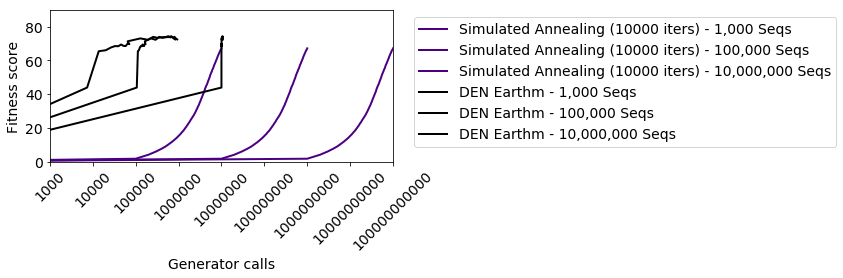

In [15]:
#Plot trajectory data

experiment_suffix = "_traj_comparisons_4_target_700_lat_penalty_09_singlesample"

model_colors = ['indigo', 'black', 'dimgrey']

figsize = (12, 4)

#Generator time scale

plot_trajectories(
    [0, 0, 0, 1, 1, 1],
    [
        "Simulated Annealing (10000 iters) - 1,000 Seqs",
        "Simulated Annealing (10000 iters) - 100,000 Seqs",
        "Simulated Annealing (10000 iters) - 10,000,000 Seqs",
        "DEN Earthm - 1,000 Seqs",
        "DEN Earthm - 100,000 Seqs",
        "DEN Earthm - 10,000,000 Seqs",
    ],
    [1000.0, 100000.0, 10000000.0, 1.0, 1.0, 1.0],
    [0.0, 0.0, 0.0, 1000.0, 100000.0, 10000000.0],
    [0, 0, 0, 0, 0, 0],
    traj_gen_xs,
    traj_ys,
    traj_names,
    0,
    'Generator calls',
    'Fitness score',
    colors=model_colors,
    min_x_val=3,
    #max_x_val=40000,
    min_y_val=0,
    max_y_val=90,
    figsize=figsize,
    save_fig=True,
    fig_name=problem_prefix + experiment_suffix + "_fitness_log_logscale",
    legend_outside=True,
    log10_scale=True
)


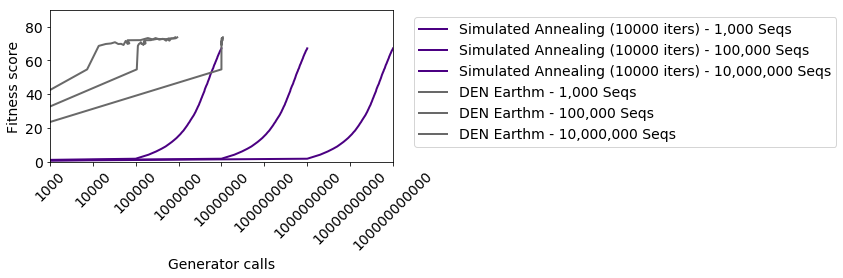

In [16]:
#Plot trajectory data

experiment_suffix = "_traj_comparisons_4_target_700_lat_penalty_07_singlesample"

model_colors = ['indigo', 'black', 'dimgrey']

figsize = (12, 4)

#Generator time scale

plot_trajectories(
    [0, 0, 0, 2, 2, 2],
    [
        "Simulated Annealing (10000 iters) - 1,000 Seqs",
        "Simulated Annealing (10000 iters) - 100,000 Seqs",
        "Simulated Annealing (10000 iters) - 10,000,000 Seqs",
        "DEN Earthm - 1,000 Seqs",
        "DEN Earthm - 100,000 Seqs",
        "DEN Earthm - 10,000,000 Seqs",
    ],
    [1000.0, 100000.0, 10000000.0, 1.0, 1.0, 1.0],
    [0.0, 0.0, 0.0, 1000.0, 100000.0, 10000000.0],
    [0, 0, 0, 0, 0, 0],
    traj_gen_xs,
    traj_ys,
    traj_names,
    0,
    'Generator calls',
    'Fitness score',
    colors=model_colors,
    min_x_val=3,
    #max_x_val=40000,
    min_y_val=0,
    max_y_val=90,
    figsize=figsize,
    save_fig=True,
    fig_name=problem_prefix + experiment_suffix + "_fitness_log_logscale_2",
    legend_outside=True,
    log10_scale=True
)


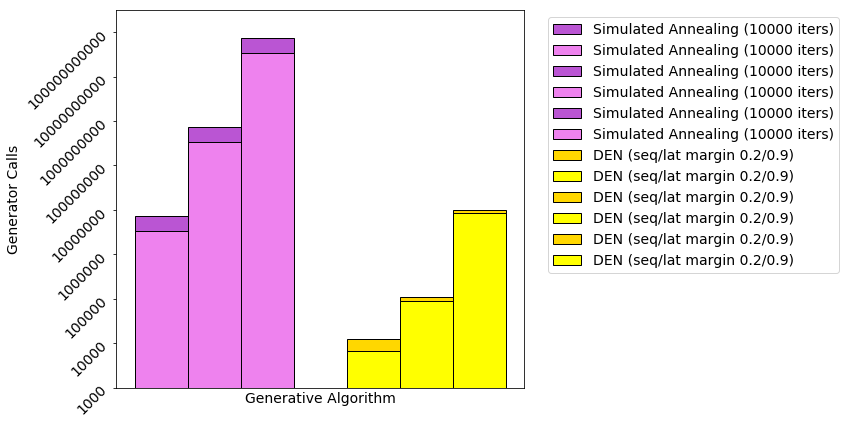

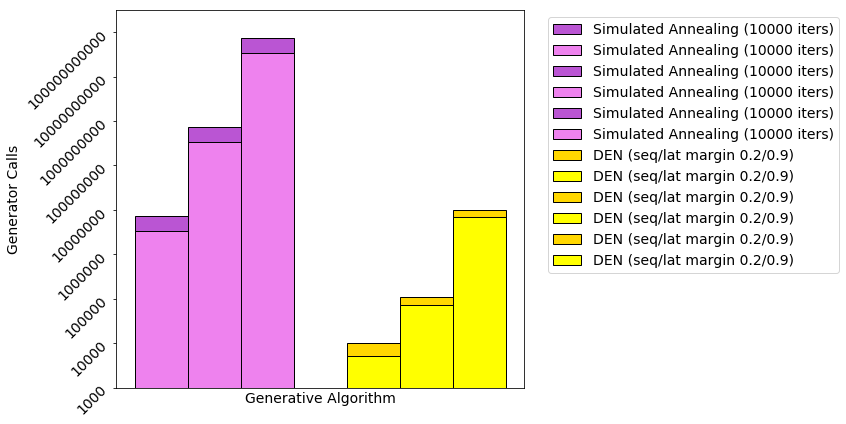

In [17]:
from scipy.interpolate import interp1d

def plot_bars(internal_traj_indices, traj_indices, traj_names, iteration_scales, iteration_constants, add_zeros, iterations, measures, model_names, measure_ix, x_label, y_label, colors=None, figsize=(6, 4), legend_outside=False, save_fig=False, fig_name="default_1", fig_dpi=150, min_x_val=0, max_x_val=None, min_y_val=None, max_y_val=None, log10_scale=False) :
    

    max_iter_val = 0
    max_meas_val = -np.inf
    
    iter_interps = []
    meas_interps = []

    for i, [model_ix, traj_name] in enumerate(zip(traj_indices, traj_names)) :
        #for model_ix, [iters, all_meas] in enumerate(zip(iterations, measures)) :

        iters, all_meas = iterations[model_ix], measures[model_ix]

        meas = np.zeros(all_meas[measure_ix, :].shape)
        meas[:] = all_meas[measure_ix, :]

        iters_copy = np.zeros(iters.shape)
        iters_copy[:] = iters[:]

        if add_zeros[i] is not None :
            iters_copy = np.concatenate([np.array([0]), iters_copy], axis=0)
            meas = np.concatenate([np.array([add_zeros[i]]), meas], axis=0)

        iters_copy[1:] = iters_copy[1:] * iteration_scales[i] + iteration_constants[i]

        max_iter_val = max(max_iter_val, np.max(iters_copy))
        max_meas_val = max(max_meas_val, np.max(meas))
        
        f_interp = interp1d(iters_copy, meas)
        
        iter_interp = np.linspace(iters_copy[0], iters_copy[-1], 1000)
        meas_interp = f_interp(iter_interp)
        
        if log10_scale :
            iter_interp[1:] = np.log10(iter_interp[1:])
        
        iter_interps.append(iter_interp)
        meas_interps.append(meas_interp)
    
    
    if log10_scale :
        max_iter_val = np.log10(max_iter_val)
    
    meas_perc_50 = 0.5 * max_meas_val
    meas_perc_80 = 0.8 * max_meas_val
    meas_perc_95 = 0.95 * max_meas_val
    meas_perc_99 = 0.99 * max_meas_val
    
    f = plt.figure(figsize=figsize)
    
    for i, [model_ix, traj_name] in enumerate(zip(internal_traj_indices, traj_names)) :
    
        iter_interp = iter_interps[i]
        meas_interp = meas_interps[i]
        
        first_iter_perc_50_ind = np.nonzero(meas_interp >= meas_perc_50)[0]
        first_iter_perc_50_ix = iter_interp[first_iter_perc_50_ind[0]] if len(first_iter_perc_50_ind) > 0 else max_iter_val
        
        first_iter_perc_80_ind = np.nonzero(meas_interp >= meas_perc_80)[0]
        first_iter_perc_80_ix = iter_interp[first_iter_perc_80_ind[0]] if len(first_iter_perc_80_ind) > 0 else max_iter_val
        
        first_iter_perc_95_ind = np.nonzero(meas_interp >= meas_perc_95)[0]
        first_iter_perc_95_ix = iter_interp[first_iter_perc_95_ind[0]] if len(first_iter_perc_95_ind) > 0 else max_iter_val
        
        first_iter_perc_99_ind = np.nonzero(meas_interp >= meas_perc_99)[0]
        first_iter_perc_99_ix = iter_interp[first_iter_perc_99_ind[0]] if len(first_iter_perc_99_ind) > 0 else max_iter_val
        
        if colors is not None :
            #plt.bar([model_ix + 0.25 * int(i % 3)], [first_iter_perc_99_ix], width=0.25, color=colors[model_ix][3], edgecolor='black', linewidth=1, label=model_names[model_ix])
            #plt.bar([model_ix + 0.25 * int(i % 3)], [first_iter_perc_95_ix], width=0.25, color=colors[model_ix][2], edgecolor='black', linewidth=1, label=model_names[model_ix])
            plt.bar([model_ix + 0.25 * int(i % 3)], [first_iter_perc_80_ix], width=0.25, color=colors[model_ix][1], edgecolor='black', linewidth=1, label=model_names[model_ix])
            plt.bar([model_ix + 0.25 * int(i % 3)], [first_iter_perc_50_ix], width=0.25, color=colors[model_ix][0], edgecolor='black', linewidth=1, label=model_names[model_ix])

    plt.xticks([], [])
    
    if log10_scale :
        plt.yticks(np.arange(int(max_iter_val) + 1), 10**np.arange(int(max_iter_val) + 1), fontsize=14, rotation=45)
    else :
        plt.yticks(fontsize=14, rotation=45)
    plt.yticks(fontsize=14)
    
    if min_x_val is not None and max_x_val :
        plt.xlim(min_x_val, max_x_val)
    
    if min_y_val is not None and max_y_val is not None :
        plt.ylim(min_y_val, max_y_val)

    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    
    if not legend_outside :
        plt.legend(fontsize=14, loc='upper left')
    else :
        plt.legend(fontsize=14, bbox_to_anchor=(1.04,1), loc="upper left")
    
    plt.tight_layout()
    
    if save_fig :
        plt.savefig(fig_name + ".eps")
        plt.savefig(fig_name + ".svg")
        plt.savefig(fig_name + ".png", dpi=fig_dpi, transparent=True)
    
    plt.show()


experiment_suffix = "_traj_comparisons_bars_4_target_700_seq_penalty_09_singlesample"

model_colors = [
    [
        'violet',
        'mediumorchid',
        'darkviolet',
        'indigo'
    ],
    [
        'yellow',
        'gold',
        'orange',
        'darkorange'
    ],
    [
        'yellow',
        'gold',
        'orange',
        'darkorange'
    ]
]

figsize = (12, 6)

#Generator time scale

plot_bars(
    [0, 0, 0, 1, 1, 1],
    [0, 0, 0, 1, 1, 1],
    [
        "Simulated Annealing (10000 iters) - 1,000 Seqs",
        "Simulated Annealing (10000 iters) - 100,000 Seqs",
        "Simulated Annealing (10000 iters) - 10,000,000 Seqs",
        "DEN Earthm - 1,000 Seqs",
        "DEN Earthm - 100,000 Seqs",
        "DEN Earthm - 10,000,000 Seqs",
    ],
    [1000.0, 100000.0, 10000000.0, 1.0, 1.0, 1.0],
    [0.0, 0.0, 0.0, 1000.0, 100000.0, 10000000.0],
    [0, 0, 0, 0, 0, 0],
    traj_gen_xs,
    traj_ys,
    traj_names,
    0,
    'Generative Algorithm',
    'Generator Calls',
    colors=model_colors,
    #min_x_val=3,
    #max_x_val=40000,
    min_y_val=3,
    max_y_val=11.5,
    figsize=figsize,
    save_fig=True,
    fig_name=problem_prefix + experiment_suffix + "_fitness_log_logscale_2",
    legend_outside=True,
    log10_scale=True
)


experiment_suffix = "_traj_comparisons_bars_4_target_700_lat_penalty_07_singlesample"

model_colors = [
    [
        'violet',
        'mediumorchid',
        'darkviolet',
        'indigo'
    ],
    [
        'yellow',
        'gold',
        'orange',
        'darkorange'
    ],
    [
        'yellow',
        'gold',
        'orange',
        'darkorange'
    ]
]

figsize = (12, 6)

#Generator time scale

plot_bars(
    [0, 0, 0, 1, 1, 1],
    [0, 0, 0, 2, 2, 2],
    [
        "Simulated Annealing (10000 iters) - 1,000 Seqs",
        "Simulated Annealing (10000 iters) - 100,000 Seqs",
        "Simulated Annealing (10000 iters) - 10,000,000 Seqs",
        "DEN Earthm - 1,000 Seqs",
        "DEN Earthm - 100,000 Seqs",
        "DEN Earthm - 10,000,000 Seqs",
    ],
    [1000.0, 100000.0, 10000000.0, 1.0, 1.0, 1.0],
    [0.0, 0.0, 0.0, 1000.0, 100000.0, 10000000.0],
    [0, 0, 0, 0, 0, 0],
    traj_gen_xs,
    traj_ys,
    traj_names,
    0,
    'Generative Algorithm',
    'Generator Calls',
    colors=model_colors,
    #min_x_val=3,
    #max_x_val=40000,
    min_y_val=3,
    max_y_val=11.5,
    figsize=figsize,
    save_fig=True,
    fig_name=problem_prefix + experiment_suffix + "_fitness_log_logscale_2",
    legend_outside=True,
    log10_scale=True
)
